In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Load the dataset
file_path = "/content/NEW_time_series_data.csv"
data = pd.read_csv(file_path)

actual_covid_data = pd.read_csv("/content/owid-covid-data.csv")
actual_covid_data = actual_covid_data[["location", "date", "total_deaths_per_million"]]


In [ ]:
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # auto-detects ISO8601 format like "2020-01-22"
data.dropna(subset=['Date'], inplace=True)  # Drop rows where date parsing failed

# filter covid data to only include the date range we are forecasting
actual_covid_data['date'] = pd.to_datetime(actual_covid_data['date'], errors='coerce')
actual_covid_data.dropna(subset=['date'], inplace=True)
actual_covid_data = actual_covid_data[(actual_covid_data['date'] >= '2022-02-01') &  (actual_covid_data['date'] <= '2023-01-01')]

# Verify the conversion
print(data['Date'].head())

0   2020-01-22
1   2020-01-23
2   2020-01-24
3   2020-01-25
4   2020-01-26
Name: Date, dtype: datetime64[ns]


In [ ]:
# Define lists of countries
high_gdp_democracy_countries = ["United States", "Germany", "United Kingdom", "Canada", "France",
                                "Japan", "Australia", "Switzerland", "Sweden", "Netherlands"]
low_gdp_democracy_countries = ["Haiti", "Zimbabwe", "Afghanistan", "Chad", "Ethiopia",
                               "Yemen", "Rwanda", "Uganda", "Mozambique", "Sudan"]

# Filter data for these countries
selected_countries = high_gdp_democracy_countries + low_gdp_democracy_countries
data = data[data['Country'].isin(selected_countries)]

In [ ]:
# Extract Year and Month from Date
data['Year-Month'] = data['Date'].dt.to_period('M')

# Group by country and year-month, aggregating by mean for consistency
monthly_data = data.groupby(['Country', 'Year-Month']).agg({
    'total_deaths_per_million': 'max',  # cumulative max at each month
    'new_deaths_per_million': 'sum',    # sum of new cases in the month
    'GDP_per_Capita': 'first',
    'Democracy score': 'first'
}).reset_index()

# Convert 'Year-Month' back to a datetime object for plotting and modeling
monthly_data['Year-Month'] = monthly_data['Year-Month'].dt.to_timestamp()

<ipython-input-4-636fcbd1408d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year-Month'] = data['Date'].dt.to_period('M')


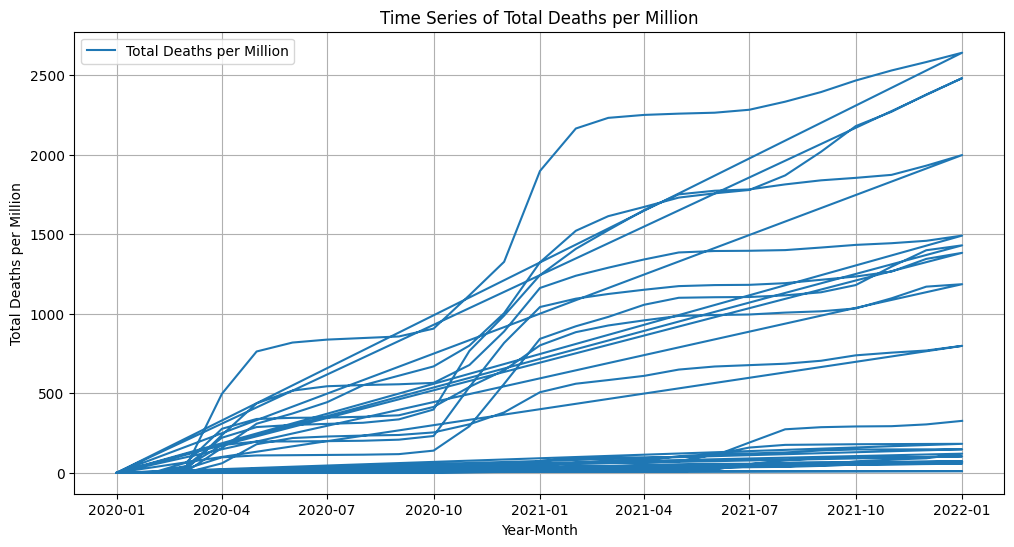

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'monthly_data' is your DataFrame
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Year-Month'], monthly_data['total_deaths_per_million'], label='Total Deaths per Million')
plt.title('Time Series of Total Deaths per Million')
plt.xlabel('Year-Month')
plt.ylabel('Total Deaths per Million')
plt.legend()
plt.grid()
plt.show()


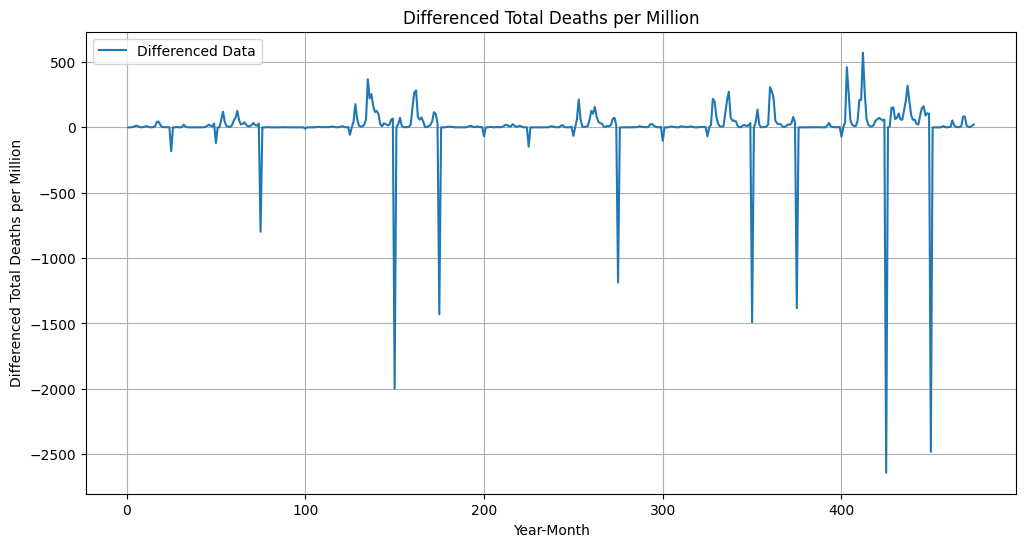

ADF Statistic: -9.032497577682623
p-value: 5.397625626885446e-15
Critical Values:
   1%: -3.444836032925901
   5%: -2.8679272692747415
   10%: -2.5701721745036776
The series is stationary (reject H0).


In [ ]:
from statsmodels.tsa.stattools import adfuller  # Import adfuller

# create a differenced series
monthly_data['first_diff'] = monthly_data['total_deaths_per_million'].diff()

# Second differencing
monthly_data['second_diff'] = monthly_data['first_diff'].diff()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data['first_diff'], label='Differenced Data')
plt.title('Differenced Total Deaths per Million')
plt.xlabel('Year-Month')
plt.ylabel('Differenced Total Deaths per Million')
plt.legend()
plt.grid()
plt.show()

result = adfuller(monthly_data['second_diff'].dropna())

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if result[1] < 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is non-stationary (fail to reject H0).")



In [ ]:
# p value is less than 0.05, meaning that the time series is already stationary.

<ipython-input-8-7aa7a2ba33d2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_data['first_diff'] = us_data['total_deaths_per_million'].diff()


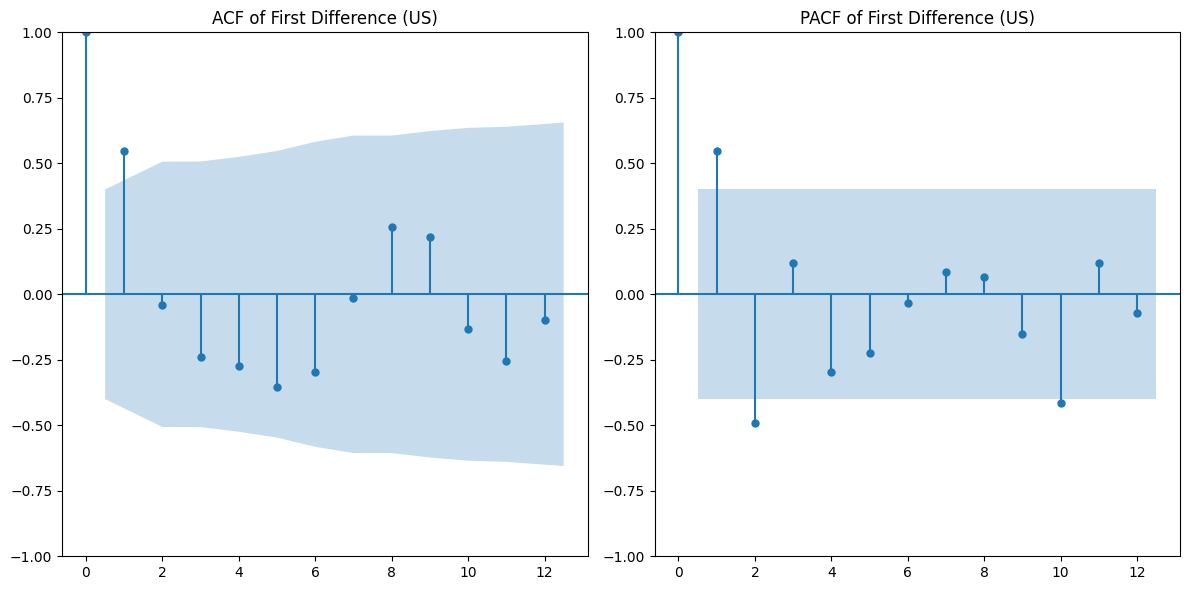

In [ ]:
# Plot ACF and PACF to identify orders
# Choose a specific country, e.g., 'United States'
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Filter data for the United States
us_data = monthly_data[monthly_data['Country'] == 'United States']

# Calculate the first difference
us_data['first_diff'] = us_data['total_deaths_per_million'].diff()

# Set the 'Year-Month' as the index
us_data = us_data.set_index('Year-Month')

# Drop NaN values resulting from the diff
first_diff = us_data['first_diff'].dropna()

# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(first_diff, lags=12, ax=plt.gca())
plt.title('ACF of First Difference (US)')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(first_diff, lags=12, ax=plt.gca())
plt.title('PACF of First Difference (US)')

plt.tight_layout()
plt.show()






/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-9-4e80b318e318>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=us_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


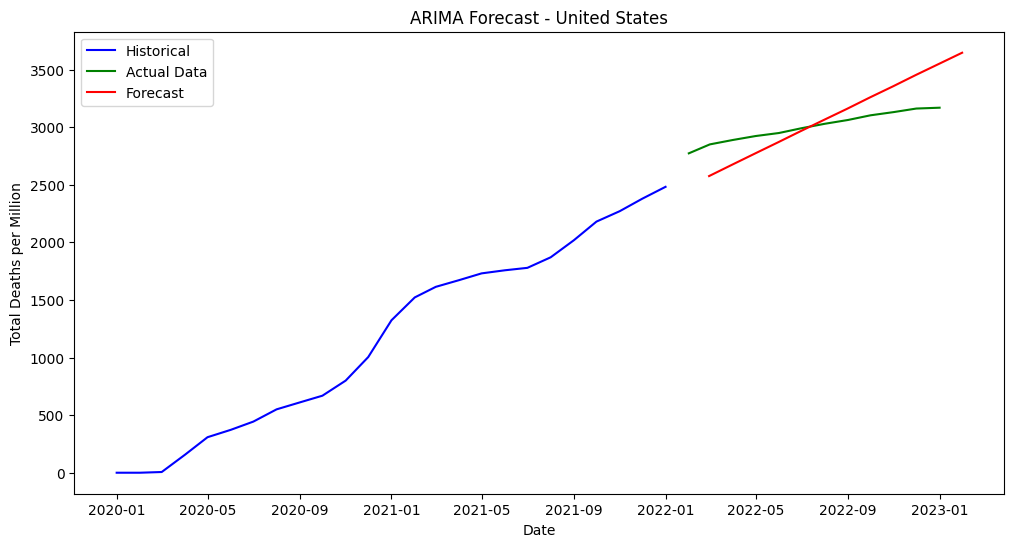

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Calculate first difference and drop NaN values
us_data['first_diff'] = us_data['total_deaths_per_million'].diff().dropna()

# Fit an ARIMA model on the first differences
arima_model = ARIMA(us_data['first_diff'].dropna(), order=(1, 1, 1))  # Correct order for differenced data
arima_model_fit = arima_model.fit()

# Forecasting the first differences for the next 12 steps
forecast_diff = arima_model_fit.forecast(steps=12)
forecast_index = pd.date_range(start=us_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_series = pd.Series(forecast_diff, index=forecast_index)

# Load and prepare actual COVID data for comparison
actual_covid_data['Year-Month'] = actual_covid_data['date'].dt.to_period('M')
actual_covid_data = actual_covid_data.groupby(['location', 'Year-Month']).agg({'total_deaths_per_million': 'max'}).reset_index()
actual_covid_data['Year-Month'] = actual_covid_data['Year-Month'].dt.to_timestamp()

# Filter actual data for the United States and forecast period
actual_us_data = actual_covid_data[(actual_covid_data['location'] == 'United States')].set_index('Year-Month')
actual_us_data_forecast_period = actual_us_data.loc[forecast_index]

# Get the last actual value to revert the differencing
last_value = us_data['total_deaths_per_million'].iloc[-1]

# Convert the forecasted first differences back to the original scale
forecast = last_value + forecast_diff.cumsum()

# Create a new date index for the forecast
forecast_index = pd.date_range(start=us_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Plotting the actual and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(us_data['total_deaths_per_million'], label='Historical', color='blue')
plt.plot(actual_us_data['total_deaths_per_million'], label='Actual Data', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast - United States')
plt.xlabel('Date')
plt.ylabel('Total Deaths per Million')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-10-b27a7a6620b8>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=us_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


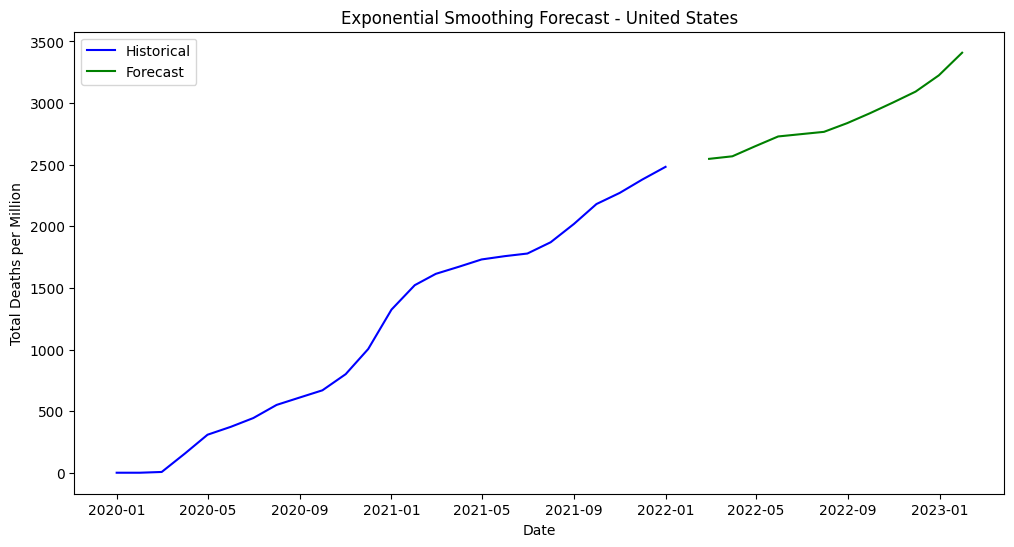

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Calculate first difference and drop NaN values
us_data['first_diff'] = us_data['total_deaths_per_million'].diff().dropna()

# Fit an Exponential Smoothing model on the first differences
exp_smoothing_model = ExponentialSmoothing(
    us_data['first_diff'].dropna(),
    trend='add',
    seasonal='add',
    seasonal_periods=12
)
exp_smoothing_model_fit = exp_smoothing_model.fit()

# Forecasting the next 12 months
exp_forecast_diff = exp_smoothing_model_fit.forecast(steps=12)

# Get the last actual value to revert the differencing
last_value = us_data['total_deaths_per_million'].iloc[-1]

# Convert the forecasted first differences back to the original scale
forecast = last_value + exp_forecast_diff.cumsum()

# Create a new date index for the forecast
forecast_index = pd.date_range(start=us_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Plotting the actual and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(us_data['total_deaths_per_million'], label='Historical', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.title('Exponential Smoothing Forecast - United States')
plt.xlabel('Date')
plt.ylabel('Total Deaths per Million')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


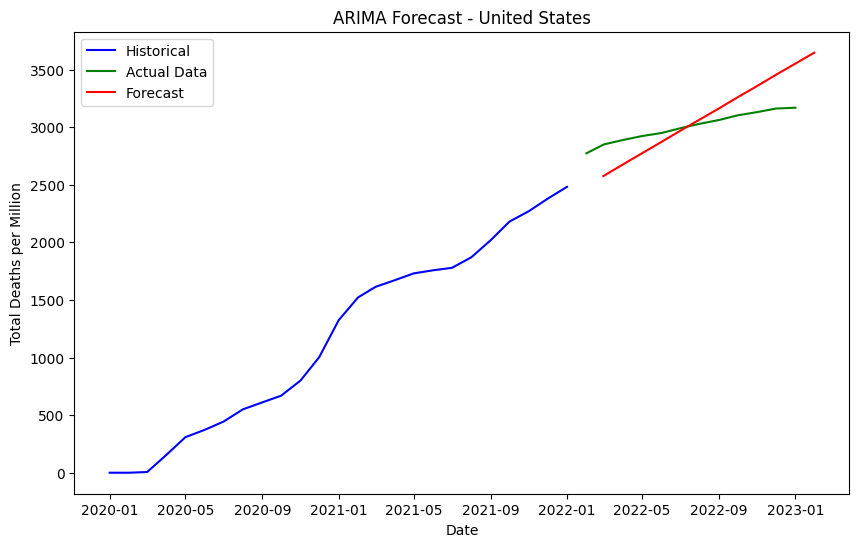

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


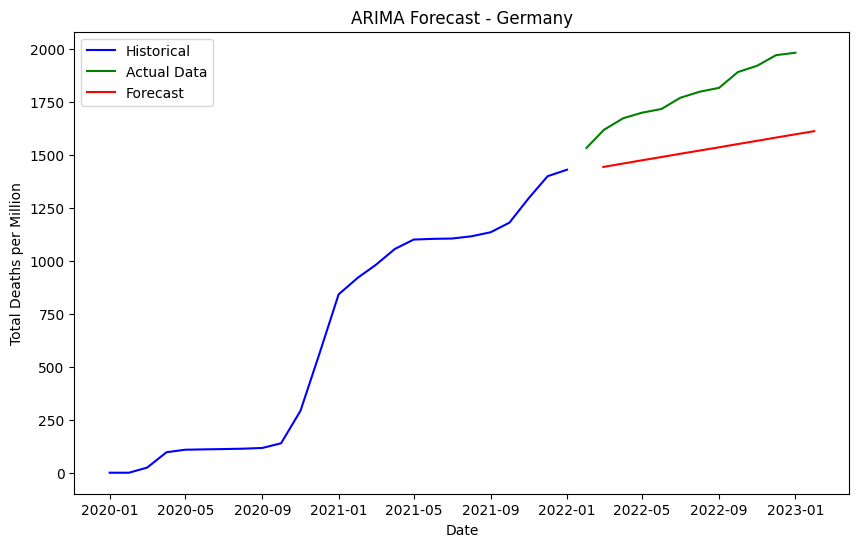

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

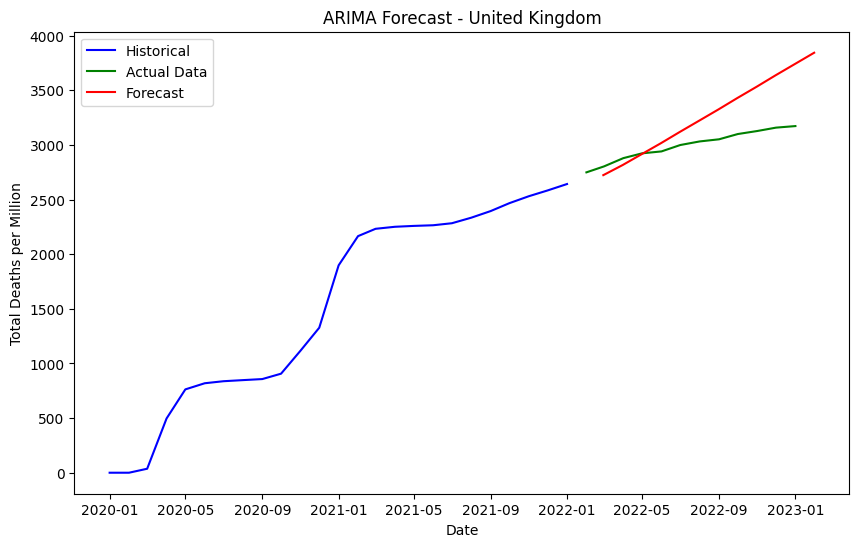

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


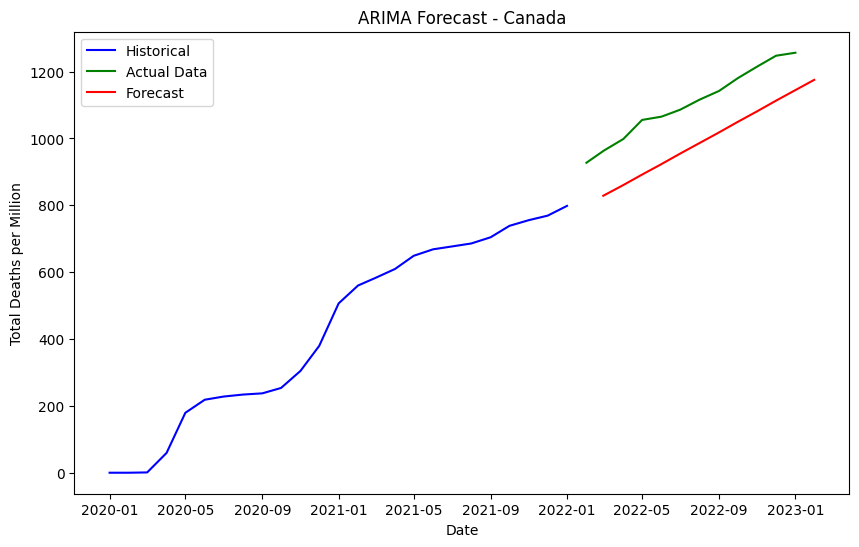

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


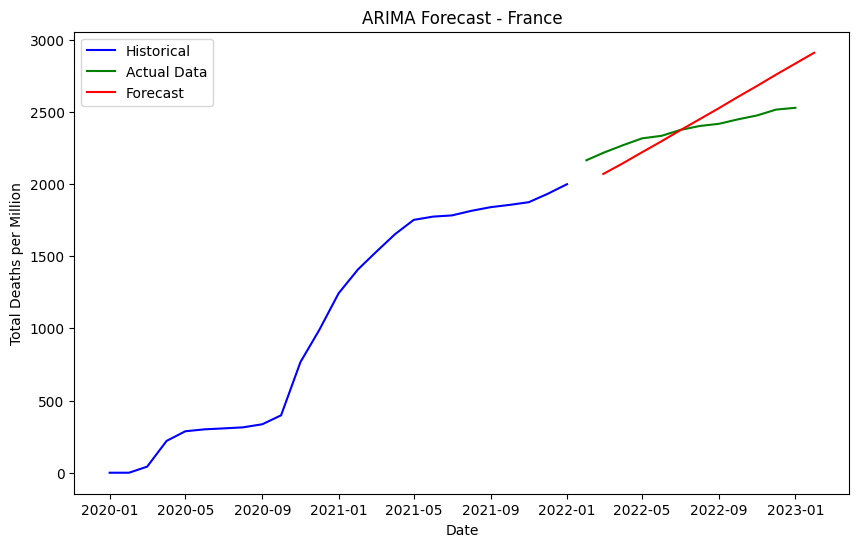

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


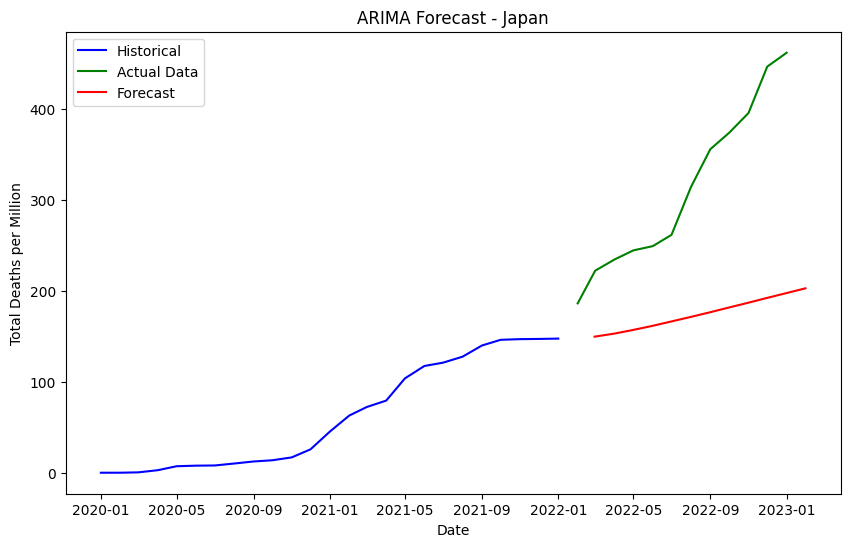

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


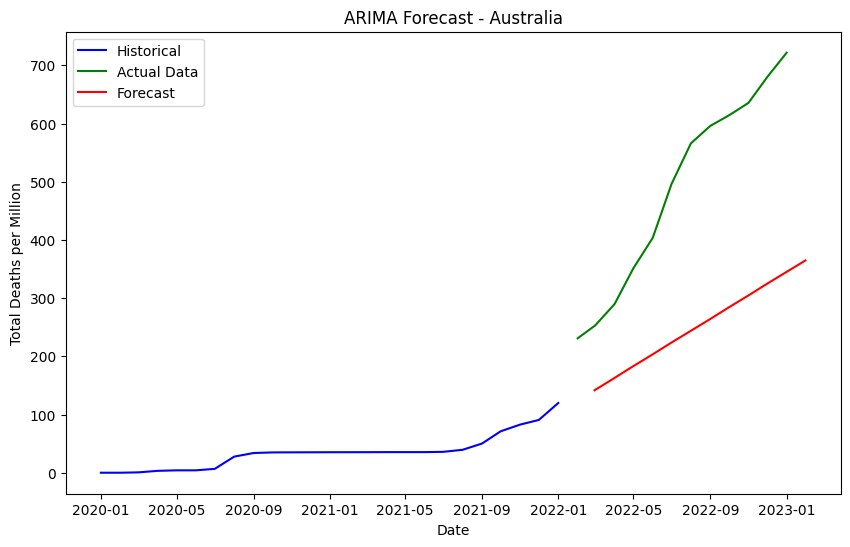

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

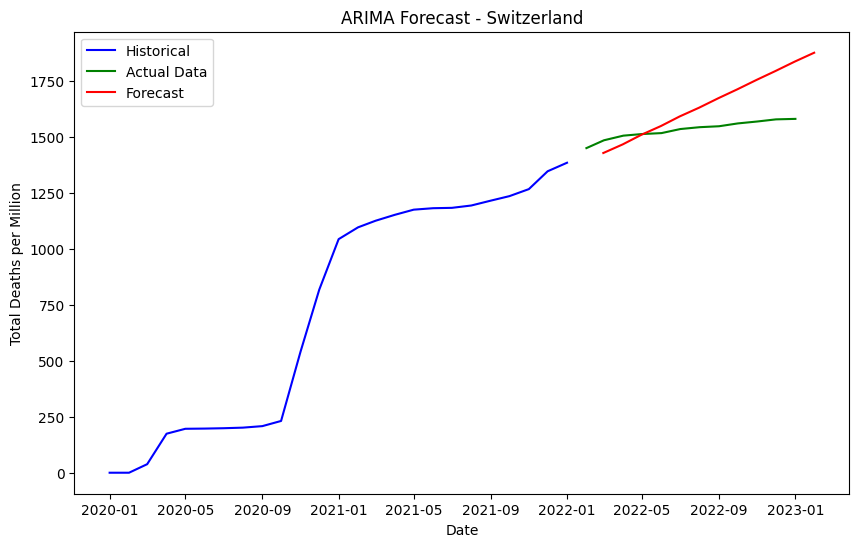

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


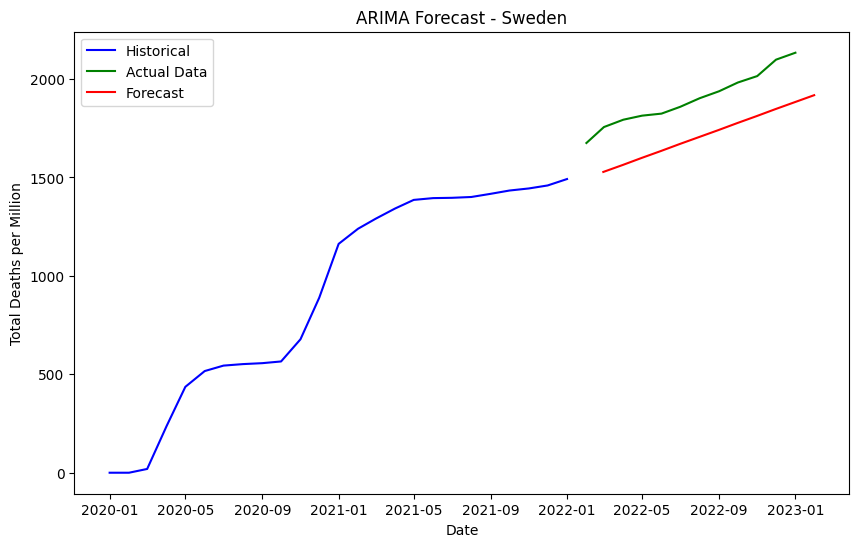

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


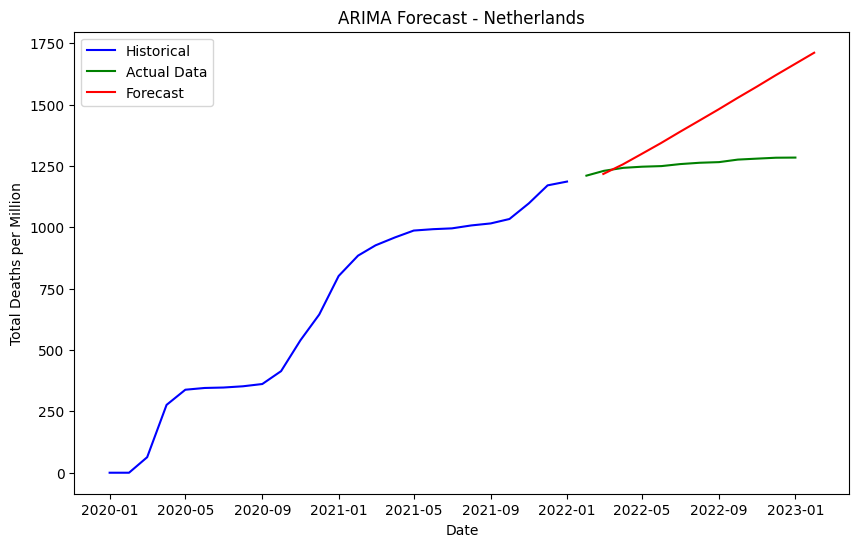

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


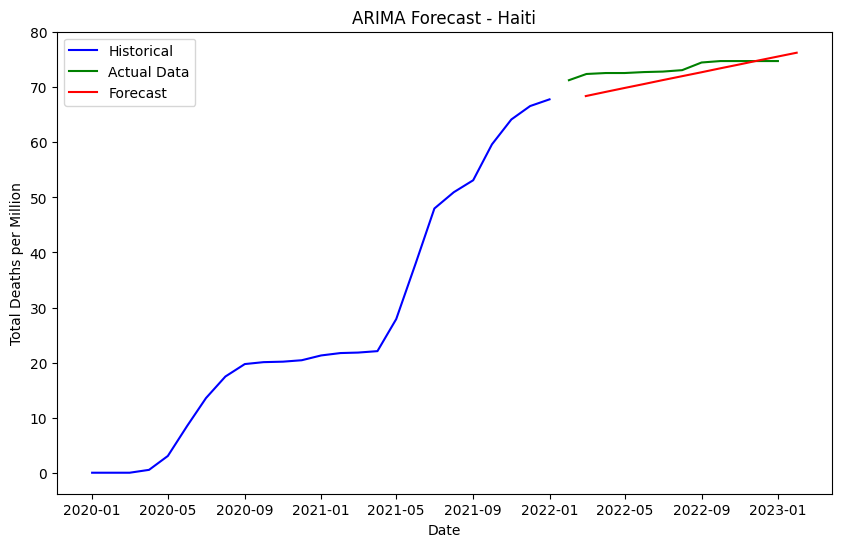

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


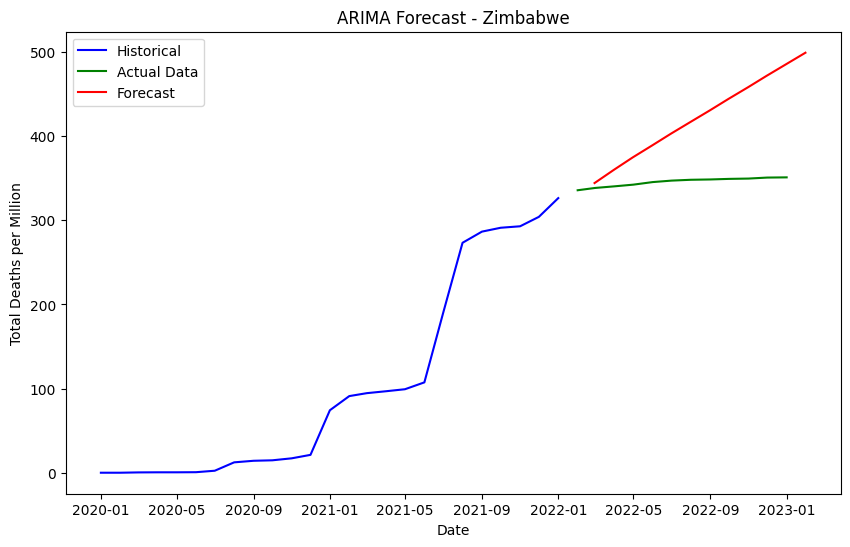

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


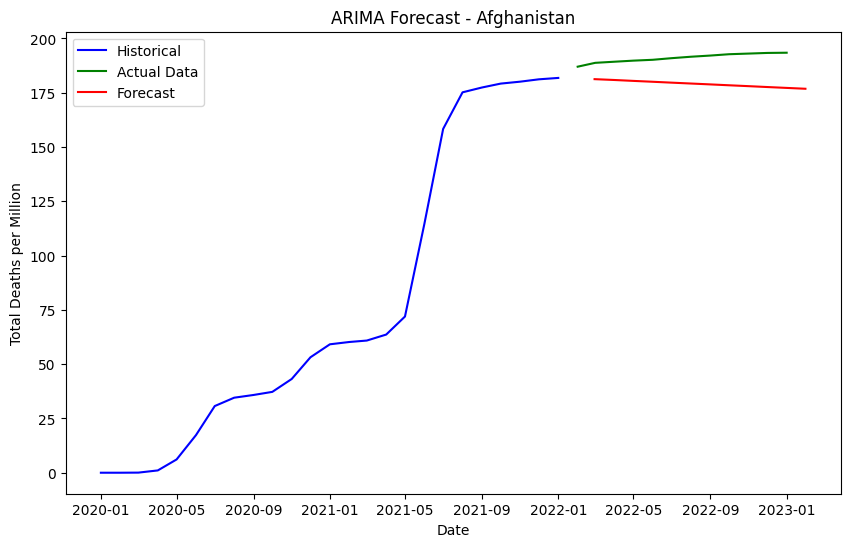

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


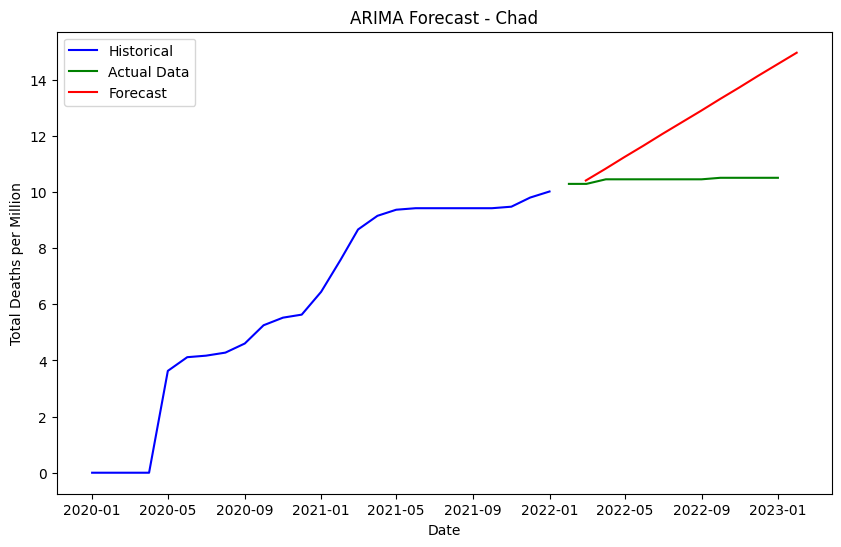

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


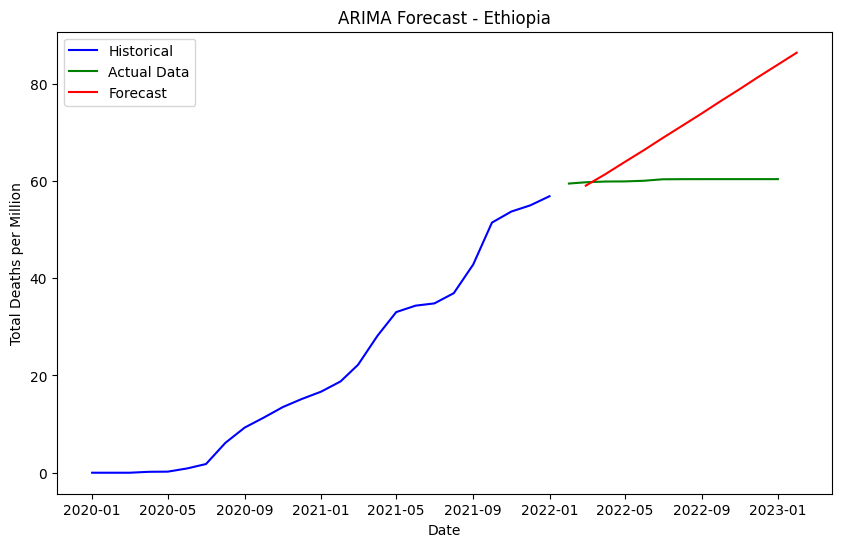

Not enough data to fit ARIMA model for Yemen.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


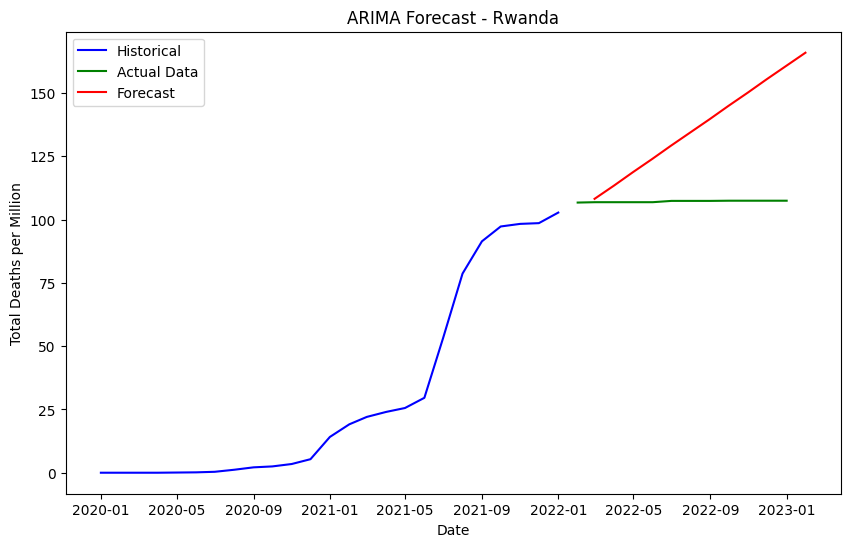

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


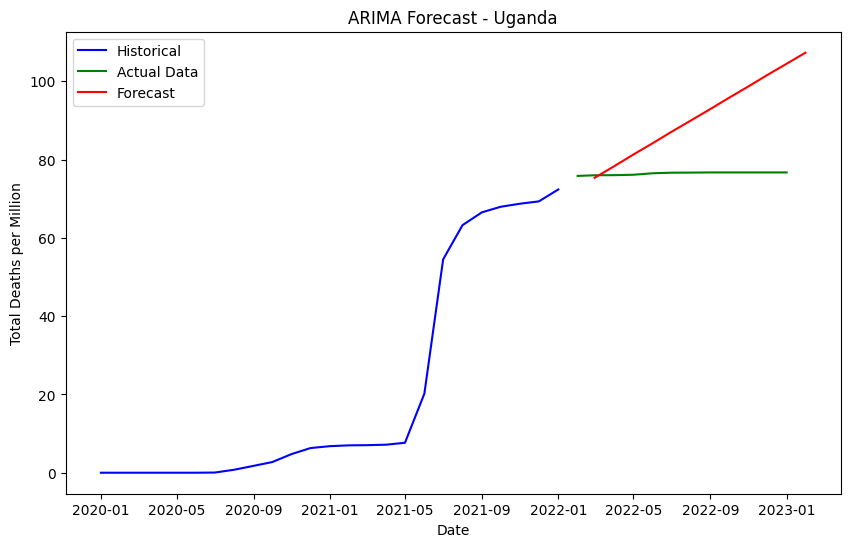

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
<ipython-input-11-9587cf90bb72>:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')


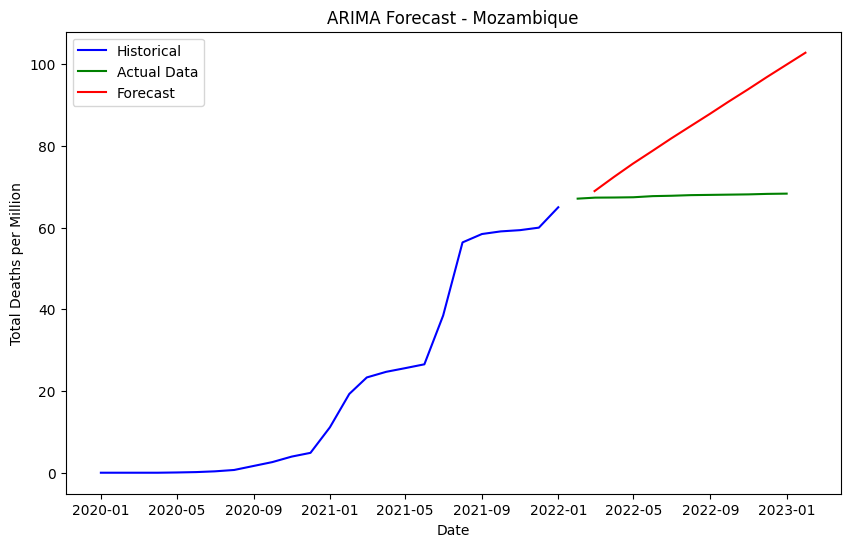

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

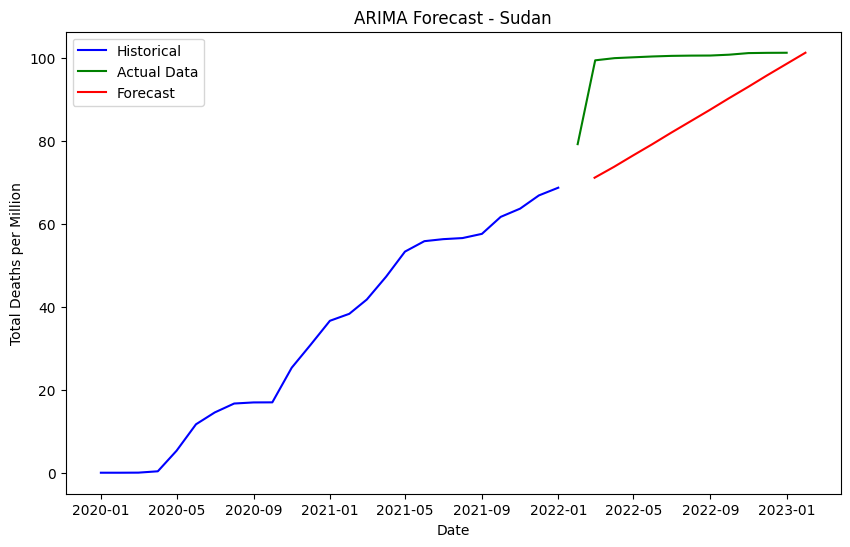

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA order
arima_order = (1, 1, 1)

# Loop through each country in the selected list
for country in selected_countries:
    # Filter data for the current country
    country_data = monthly_data[monthly_data['Country'] == country].set_index('Year-Month')
    actual_country_data = actual_covid_data[actual_covid_data['location'] == country].set_index('Year-Month')
    # Check if there is enough data to fit the model
    if len(country_data) > 12:  # Require at least 12 months of data
        try:
            # Calculate first difference
            country_data['first_diff'] = country_data['total_deaths_per_million'].diff().dropna()

            # Fit the ARIMA model on the first differences
            arima_model = ARIMA(country_data['first_diff'].dropna(), order=arima_order)
            arima_model_fit = arima_model.fit()

            # Forecast the next 12 months of first differences
            forecast_diff = arima_model_fit.forecast(steps=12)

            # Get the last actual value to revert the differencing
            last_value = country_data['total_deaths_per_million'].iloc[-1]

            # Convert the forecasted first differences back to the original scale
            forecast = last_value + forecast_diff.cumsum()

            # Create a new date index for the forecast
            forecast_index = pd.date_range(start=country_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
            forecast_series = pd.Series(forecast, index=forecast_index)
            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(country_data['total_deaths_per_million'], label='Historical', color='blue')
            plt.plot(actual_country_data['total_deaths_per_million'], label='Actual Data', color='green')
            plt.plot(forecast_index, forecast, label='Forecast', color='red')
            plt.title(f'ARIMA Forecast - {country}')
            plt.xlabel('Date')
            plt.ylabel('Total Deaths per Million')
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"ARIMA model could not be fit for {country}. Error: {e}")
    else:
        print(f"Not enough data to fit ARIMA model for {country}.")



In [ ]:


# Initialize an empty dictionary to store forecasts
forecast_dict = {}

# Define ARIMA order for second differencing (e.g., (p, 2, q))
arima_order = (1, 2, 1)  # Set p and q based on your model choice

# Loop through each country and store forecasts
for country in selected_countries:
    country_data = monthly_data[monthly_data['Country'] == country].set_index('Year-Month')

    # Ensure there's enough data after second differencing
    if len(country_data['first_diff'].dropna()) > 12:
        try:
            # Fit ARIMA model on the second-differenced data
            arima_model = ARIMA(country_data['second_diff'].dropna(), order=arima_order)
            arima_model_fit = arima_model.fit()
            forecast = arima_model_fit.forecast(steps=12)

            # Store forecast in dictionary
            forecast_dict[country] = forecast

        except Exception as e:
            print(f"ARIMA model could not be fit for {country}. Error: {e}")
    else:
        print(f"Not enough data to fit ARIMA model for {country}.")

# Convert forecasts to DataFrame for easy handling
forecast_df = pd.DataFrame(forecast_dict)
print(forecast_df.head())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Not enough data to fit ARIMA model for Yemen.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

            United States    Germany  United Kingdom     Canada     France  \
2022-02-01      42.178909   0.388365        0.071524   5.691235  28.869712   
2022-03-01      19.434983 -58.652213        4.394190  16.134362  19.837777   
2022-04-01      66.631818  13.882729        4.199518  12.259970  27.555758   
2022-05-01      43.888967 -45.153426        6.078842  18.351664  25.527226   
2022-06-01      91.084727  27.377094        7.005955  17.506202  29.170036   

               Japan  Australia  Switzerland     Sweden  Netherlands  \
2022-02-01 -0.188297  -1.132230    42.056316  16.879824   -29.789953   
2022-03-01  0.366641  21.213366     3.419397  20.004171   -42.199116   
2022-04-01  0.106376   1.039552    50.899471  22.113892   -37.436190   
2022-05-01  0.601946  21.485566    37.694623  24.502410   -39.957827   
2022-06-01  0.396725   3.126469    67.253225  26.814321   -39.389283   

                Haiti   Zimbabwe  Afghanistan       Chad  Ethiopia     Rwanda  \
2022-02-01  17.05

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


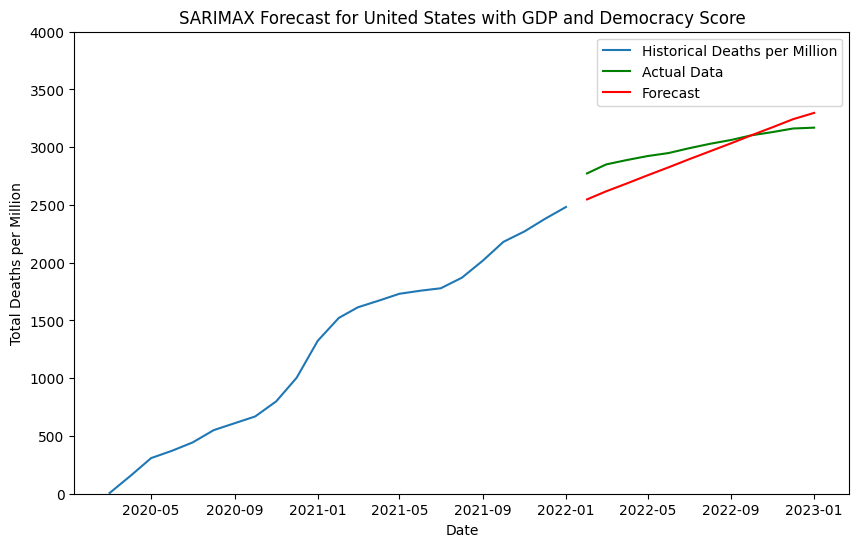

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Filter data for a specific country
country = "United States"  # Example country
country_data = monthly_data[monthly_data['Country'] == country].set_index('Year-Month')

# Make sure data is complete and aligned
country_data = country_data[['total_deaths_per_million', 'GDP_per_Capita', 'Democracy score']].dropna()

# Calculate the first and second differences
country_data['first_diff'] = country_data['total_deaths_per_million'].diff()
country_data['second_diff'] = country_data['first_diff'].diff()

# Drop NaN values resulting from differencing
country_data = country_data.dropna()

# Define the endogenous and exogenous variables
endog = country_data['first_diff']
exog = country_data[['GDP_per_Capita', 'Democracy score']]

# Fit the SARIMAX model
model = SARIMAX(endog, exog=exog, order=(1, 1, 1))
model_fit = model.fit(disp=False)

# Forecast for the next 12 months using the last available GDP and Democracy score values
forecast = model_fit.get_forecast(steps=12, exog=exog[-12:])
forecast_ci = forecast.conf_int(alpha=0.10)  # Set alpha to 0.10 for a 90% confidence interval

# Back-transform the forecast to the original scale
last_value = country_data['total_deaths_per_million'].iloc[-1]
forecast_values = last_value + forecast.predicted_mean.cumsum()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(country_data['total_deaths_per_million'], label='Historical Deaths per Million')
plt.plot(actual_us_data['total_deaths_per_million'], label='Actual Data', color='green')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')

#plt.fill_between(forecast_ci.index,
                 #last_value + forecast_ci.iloc[:, 0].cumsum(),
                 #last_value + forecast_ci.iloc[:, 1].cumsum(),
                 #color='pink', alpha=0.3)

plt.title(f'ARIMAX Forecast for {country} with GDP and Democracy Score')
plt.xlabel('Date')
plt.ylabel('Total Deaths per Million')
plt.ylim(0, 4000)  # Set y-axis limits
plt.legend()
plt.show()




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize a dictionary to store results for each country
results = []

# Loop over the list of selected countries
for country in selected_countries:  # Replace 'selected_countries' with your list of country names
    # Filter data for each country
    country_data = monthly_data[monthly_data['Country'] == country].set_index('Year-Month')

    # Make sure data is complete and aligned
    country_data = country_data[['total_deaths_per_million', 'GDP_per_Capita', 'Democracy score']].dropna()

    # Calculate the first difference
    country_data['first_diff'] = country_data['total_deaths_per_million'].diff()
    country_data = country_data.dropna()  # Drop NaN values from differencing

    # Define the endogenous and exogenous variables
    endog = country_data['first_diff']
    exog = country_data[['GDP_per_Capita', 'Democracy score']]

    # Fit the SARIMAX model
    try:
        model = SARIMAX(endog, exog=exog, order=(1, 0, 1))  # d=0 because we are already differenced
        model_fit = model.fit(disp=False)

        # Perform a 12-month forecast
        forecast = model_fit.get_forecast(steps=12, exog=exog[-12:])
        forecast_values = forecast.predicted_mean


        # Get the last actual value to back-transform the forecast
        last_actual_value = country_data['total_deaths_per_million'].iloc[-1]

        # Back-transform the forecast to the original scale
        forecast_original = last_actual_value + forecast_values.cumsum()

        # Use the last 12 values as the "actual" data for error metrics
        actual_values = country_data['total_deaths_per_million'].iloc[-12:]

        # Calculate error metrics
        mae = mean_absolute_error(actual_values, forecast_original)
        mse = mean_squared_error(actual_values, forecast_original)
        rmse = sqrt(mse)
        mape = np.mean(np.abs((actual_values - forecast_original) / actual_values)) * 100

        # Append the results to the list
        results.append({
            'Country': country,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        })

    except Exception as e:
        print(f"Modeling failed for {country}: {e}")

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)
print(results_df)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Modeling failed for Yemen: zero-size array to reduction operation maximum which has no identity


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

           Country          MAE           MSE         RMSE  MAPE
0    United States  1200.379256  1.449915e+06  1204.124274   NaN
1          Germany   679.718795  4.727094e+05   687.538684   NaN
2   United Kingdom   896.424140  8.458457e+05   919.698708   NaN
3           Canada   325.837624  1.078531e+05   328.410014   NaN
4           France   676.102646  4.692495e+05   685.017914   NaN
5            Japan    72.162725  5.336944e+03    73.054391   NaN
6        Australia   132.539690  1.779904e+04   133.413054   NaN
7      Switzerland   397.838446  1.617747e+05   402.212267   NaN
8           Sweden   364.188556  1.419399e+05   376.749075   NaN
9      Netherlands   390.961876  1.563388e+05   395.396958   NaN
10           Haiti    42.649847  1.855863e+03    43.079729   NaN
11        Zimbabwe   282.803753  8.102391e+04   284.646992   NaN
12     Afghanistan    85.306629  8.324130e+03    91.236668   NaN
13            Chad     3.144786  1.067810e+01     3.267736   NaN
14        Ethiopia    31.

In [ ]:
# MAE Mean Absolute Error
# lowest MAE is for Sudan (30.307) indicating that on average, the model's forecast
# deviates from the actual number of deaths by 30.307 deaths per million
# highest MAE is for United States( 1200.34) suggesting that forecasts for the UK deviate
# by a larger margin on average compared to other countries

In [ ]:
# countries with low MAE, MSE, and RMSE (Chad, Haiti, and Uganda) indicate that
# the model has generally lower forecasting errors in these locations
# countries with high values in these metrics (UK, US, France) suggest that the
# model's forecasts for these countries were less accurate
# this may be due to factors like higher variance in COVID-19 deaths or model
# limitations in capturing country-specific trends